In [1]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import seaborn as sns
import pandas as pd 
from collections import Counter
import yaml
from PIL import Image

In [2]:
import shutil
import os

# Define source and destination paths
src_dir = "/kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov11/"
dst_dir = "/kaggle/working/BrainTumorYolov11/"

# Copy dataset to writable directory
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)

print("✅ Dataset copied to working directory!")


✅ Dataset copied to working directory!


In [3]:
# Load the YAML file
yaml_path = "/kaggle/working/BrainTumorYolov11/data.yaml"  # Update this
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

# Extract class names
class_names = data_yaml["names"]
num_classes = data_yaml["nc"]

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 3
Class names: ['glioma', 'meningioma', 'pituitary']


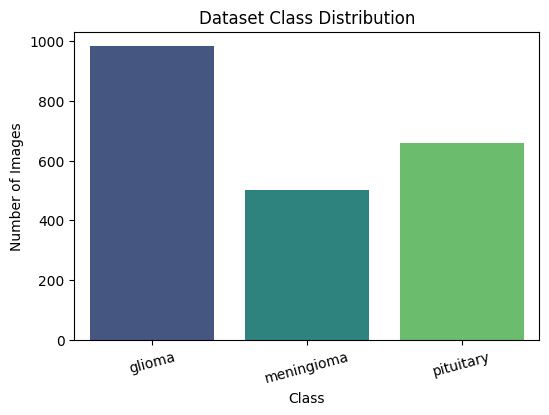

In [4]:
# Define paths
base_path = "/kaggle/working/BrainTumorYolov11/train/labels"  # Update this

# Count occurrences of each class in the dataset
class_counts = {name: 0 for name in class_names}

for label_file in os.listdir(base_path):
    with open(os.path.join(base_path, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_idx = int(line.split()[0])  # Get class index
            class_counts[class_names[class_idx]] += 1
class_counts_df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(data=class_counts_df, x="Class", y="Count", palette="viridis")
plt.title("Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()



In [5]:
import os
import collections

# Define paths
label_dir = "/kaggle/working/BrainTumorYolov11/train/labels"

# Count labels per class
class_counts = collections.defaultdict(int)

# Read label files
for label_file in os.listdir(label_dir):
    with open(os.path.join(label_dir, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID (assuming first value in YOLO format)
            class_counts[class_id] += 1

# Print class distribution
print("Class Distribution Before Balancing:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

# Find the target count (max of any class)
target_count = min(class_counts.values())
print(f"\nTarget count for all classes: {target_count}")


Class Distribution Before Balancing:
Class 0: 983 images
Class 1: 503 images
Class 2: 658 images

Target count for all classes: 503


In [6]:
import shutil
import random

# Define paths
train_images_dir = "/kaggle/working/BrainTumorYolov11/train/images"
train_labels_dir = "/kaggle/working/BrainTumorYolov11/train/labels"

# Target count (smallest class count)
target_count = min(class_counts.values())  # 503 in this case

# Get all class 0 files
class_0_files = []
for lbl_file in os.listdir(train_labels_dir):
    with open(os.path.join(train_labels_dir, lbl_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            if int(line.split()[0]) == 0:  # Check if it's Class 0
                class_0_files.append(lbl_file)
                break  # Only need to check the first line

# Randomly select Class 0 files to keep
files_to_keep = set(random.sample(class_0_files, target_count))
files_removed = []

# Remove extra files
for lbl_file in class_0_files:
    if lbl_file not in files_to_keep:
        img_file = lbl_file.replace(".txt", ".jpg")

        src_label = os.path.join(train_labels_dir, lbl_file)
        src_image = os.path.join(train_images_dir, img_file)

        # Move to a backup folder instead of deleting (optional)
        backup_dir = "/kaggle/working/removed_samples"
        os.makedirs(backup_dir, exist_ok=True)
        shutil.move(src_label, os.path.join(backup_dir, lbl_file))
        shutil.move(src_image, os.path.join(backup_dir, img_file))

        files_removed.append(lbl_file)

print("\n✅ **Undersampling Completed!**")
print(f"🗑 Removed {len(files_removed)} files from Class 0")



✅ **Undersampling Completed!**
🗑 Removed 480 files from Class 0


In [7]:
# Recalculate class distribution after undersampling
from collections import Counter
import os

train_labels_dir = "/kaggle/working/BrainTumorYolov11/train/labels"

final_class_counts = Counter()
for lbl_file in os.listdir(train_labels_dir):
    with open(os.path.join(train_labels_dir, lbl_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID
            final_class_counts[class_id] += 1

print("\n✅ **Final Class Distribution After Undersampling:**")
for class_id, count in final_class_counts.items():
    print(f"Class {class_id}: {count} images")



✅ **Final Class Distribution After Undersampling:**
Class 2: 658 images
Class 1: 503 images
Class 0: 503 images


In [8]:
import yaml

# Path to data.yaml in the working directory
yaml_path = "/kaggle/working/BrainTumorYolov11/data.yaml"

# Load the existing YAML file
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)

# Add/Modify augmentation settings (YOLOv12 supports these augmentations)
data["augment"] = {
    "mosaic": True,
    "mixup": 0.2,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "perspective": 0.0005,
    "shear": 0.0001,
    "flipud": 0.5,
    "fliplr": 0.5,
    "rotate": 5.0,
    "scale": 0.5
}

# Save the updated YAML file
with open(yaml_path, "w") as file:
    yaml.dump(data, file, default_flow_style=False)

print("✅ `data.yaml` updated successfully with on-the-fly augmentations!")


✅ `data.yaml` updated successfully with on-the-fly augmentations!


✅ Image loaded successfully!


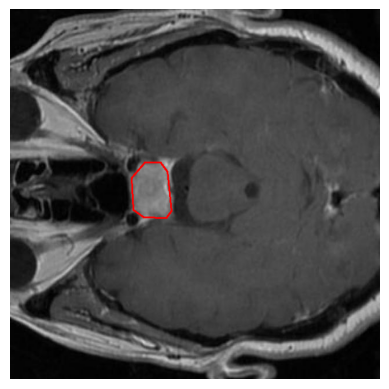

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/kaggle/working/BrainTumorYolov11/train/images/1008_jpg.rf.b5c98342f457ce16526ec486f87d3b16.jpg"
label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
# Ensure the image exists before processing
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    
    if img is not None:  # Check if image is successfully read
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("✅ Image loaded successfully!")
    else:
        print("⚠️ Error: Image could not be loaded. Possible corruption:", img_path)
else:
    print("❌ Image path does not exist:", img_path)
# Example: Load an image and overlay its polygon annotation


# Read image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Read annotations
with open(label_path, "r") as f:
    lines = f.readlines()

for line in lines:
    values = list(map(float, line.split()))
    class_id = int(values[0])
    polygon = values[1:]  # Polygon coordinates

    # Convert YOLO polygon format to image points
    points = [(int(polygon[i] * img.shape[1]), int(polygon[i+1] * img.shape[0])) for i in range(0, len(polygon), 2)]
    
    # Draw polygon
    cv2.polylines(img, [np.array(points)], isClosed=True, color=(255, 0, 0), thickness=2)

# Show image with annotations
plt.imshow(img)
plt.axis("off")
plt.show()


In [10]:
import yaml

# Define the correct paths for your dataset
data_yaml_path = "/kaggle/working/BrainTumorYolov11/data.yaml"  # Save in working directory

correct_paths = {
    "train": "/kaggle/working/BrainTumorYolov11/train/images",  # Update this path
    "val": "/kaggle/working/BrainTumorYolov11/valid/images",  # Update this path
    "test": "/kaggle/working/BrainTumorYolov11/test/images",  # Update this path
    "nc": 3,  # Number of classes
    "names": ["glioma", "meningioma", "pituitary"]  # Class names
}

# Save the updated data.yaml
with open(data_yaml_path, "w") as file:
    yaml.dump(correct_paths, file, default_flow_style=False)

print(f"✅ Updated data.yaml saved at: {data_yaml_path}")


✅ Updated data.yaml saved at: /kaggle/working/BrainTumorYolov11/data.yaml


In [11]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 43.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
from ultralytics import YOLO
model = YOLO("yolo12l.pt")

100%|██████████| 51.2M/51.2M [00:02<00:00, 26.0MB/s]


In [14]:
import time

# Start time
start_time = time.time()

# Train the model
results = model.train(
   data='/kaggle/working/BrainTumorYolov11/data.yaml',
   imgsz=128,
   epochs=150,
   batch=16,
   name='yolo12l.pt',
)

# End time
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = int(total_time % 60)

# Display training summary
print(f"✅ Training Completed!")
print(f"🕒 Time Taken: {minutes} min {seconds} sec")
print(f"🔄 Total Epochs: {results.epochs}")


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo12l.pt, data=/kaggle/working/BrainTumorYolov11/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo12l.pt, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 159MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  4   4272944  ultralytics.nn.modules.block.A2C2f           [512, 512, 4, True, 4, True, 1.2]
  7                  -1  1   2360320  ultralyt

100%|██████████| 5.35M/5.35M [00:00<00:00, 401MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/BrainTumorYolov11/train/labels... 1664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1664/1664 [00:01<00:00, 1069.47it/s]

train: New cache created: /kaggle/working/BrainTumorYolov11/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1663, len(boxes) = 1664. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/BrainTumorYolov11/valid/labels... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<00:00, 1000.49it/s]


val: New cache created: /kaggle/working/BrainTumorYolov11/valid/labels.cache
Plotting labels to runs/detect/yolo12l.pt/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0005), 211 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 4 dataloader workers
Logging results to runs/detect/yolo12l.pt
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.34G      1.827      2.109      1.215         25        128: 100%|██████████| 104/104 [00:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

                   all        612        612      0.205       0.33     0.0937      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.35G      1.834        1.7      1.181         35        128: 100%|██████████| 104/104 [00:20<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


                   all        612        612      0.325      0.347      0.272      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.35G      1.882       1.69      1.188         25        128: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]

                   all        612        612      0.278      0.456      0.346      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.35G      1.804      1.594      1.174         18        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.30it/s]

                   all        612        612      0.585      0.548      0.547       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.35G      1.714      1.539      1.138         18        128: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


                   all        612        612      0.518      0.524      0.544      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.35G      1.672      1.436      1.107         31        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


                   all        612        612      0.796      0.437      0.532      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.35G      1.597      1.361      1.114         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.92it/s]

                   all        612        612      0.712      0.564       0.63      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.35G      1.544      1.318      1.076         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


                   all        612        612      0.657      0.552       0.59      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.35G      1.545      1.288      1.075         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]

                   all        612        612      0.619      0.611      0.628      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.35G      1.477      1.238      1.064         24        128: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


                   all        612        612      0.764      0.689       0.75      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.35G      1.489      1.214      1.067         33        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.92it/s]

                   all        612        612      0.643      0.584      0.633      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.35G      1.453      1.176      1.061         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]

                   all        612        612      0.721      0.596      0.667      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.35G      1.445       1.16      1.073         24        128: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]

                   all        612        612      0.749       0.63      0.715      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.35G      1.418      1.118      1.058         14        128: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]

                   all        612        612      0.785      0.672      0.727      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.35G      1.422      1.128      1.053         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.94it/s]

                   all        612        612      0.709      0.642       0.72      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.35G      1.449      1.139      1.064         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.39it/s]

                   all        612        612      0.742      0.678      0.724      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.35G      1.386       1.09      1.046         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]

                   all        612        612      0.762      0.667      0.735      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.35G      1.354      1.088      1.023         20        128: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


                   all        612        612       0.72      0.683      0.734      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.35G      1.297      1.045      1.017         17        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.33it/s]

                   all        612        612      0.728       0.71      0.755      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.35G      1.374      1.053      1.043         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.43it/s]

                   all        612        612      0.774      0.652      0.725      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.35G      1.325      1.045      1.029         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]

                   all        612        612       0.76      0.743      0.794      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.35G      1.324      1.015      1.034         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]

                   all        612        612      0.734      0.742      0.784      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.35G      1.275      1.005       1.01         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.39it/s]


                   all        612        612      0.789      0.693       0.78      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.35G      1.276      1.009      1.023         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.29it/s]

                   all        612        612      0.838      0.682      0.774      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.35G      1.263     0.9706      1.004         33        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


                   all        612        612      0.785      0.715      0.786      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.35G      1.306      0.995      1.029         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


                   all        612        612      0.751      0.765      0.801      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.35G      1.264      0.951      1.025         31        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]

                   all        612        612      0.776      0.721      0.801       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.35G      1.259     0.9435      1.011         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.37it/s]


                   all        612        612      0.754       0.71      0.771      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.35G      1.237     0.9079      1.001         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]

                   all        612        612      0.792      0.728      0.794      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.35G       1.26     0.9418      1.016         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


                   all        612        612      0.812      0.722      0.789      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.35G      1.248     0.9293      1.004         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]

                   all        612        612      0.803       0.75      0.822      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.35G      1.203     0.9042      1.005         15        128: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


                   all        612        612       0.78      0.755      0.817      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.35G      1.231     0.9232     0.9972         26        128: 100%|██████████| 104/104 [00:20<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


                   all        612        612      0.739      0.704      0.774      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.35G      1.235     0.9279      1.008         22        128: 100%|██████████| 104/104 [00:20<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]

                   all        612        612      0.782       0.76      0.802      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.35G      1.183     0.8851     0.9951         21        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]

                   all        612        612      0.847      0.742      0.829      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.35G      1.182     0.8576     0.9801         26        128: 100%|██████████| 104/104 [00:20<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


                   all        612        612      0.734      0.787      0.806      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.35G      1.176      0.883     0.9907         20        128: 100%|██████████| 104/104 [00:20<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.40it/s]


                   all        612        612      0.774       0.79      0.842      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.35G      1.203     0.8966     0.9995         21        128: 100%|██████████| 104/104 [00:20<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]

                   all        612        612      0.735      0.741      0.806      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.35G      1.224     0.8738      1.005         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]

                   all        612        612      0.815      0.767      0.825      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.35G      1.166     0.8444     0.9725         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


                   all        612        612      0.769      0.738      0.782      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.35G      1.164     0.8229     0.9884         27        128: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.37it/s]

                   all        612        612      0.818      0.735        0.8      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.35G      1.171     0.8638     0.9959         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


                   all        612        612      0.785      0.775      0.817      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.35G      1.169     0.8027     0.9767         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


                   all        612        612      0.803      0.753      0.812      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.35G      1.169     0.8332     0.9948         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


                   all        612        612      0.753       0.74      0.781       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.35G      1.192     0.8363     0.9974         20        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]

                   all        612        612      0.806      0.739      0.806      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.35G      1.148     0.7935     0.9724         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.18it/s]

                   all        612        612      0.848      0.769      0.835      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.35G      1.161       0.84     0.9872         25        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


                   all        612        612       0.83      0.756      0.828      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.35G       1.17     0.8488     0.9812         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


                   all        612        612      0.834      0.761      0.825      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.35G      1.102      0.776     0.9611         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


                   all        612        612      0.836       0.74      0.831      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.35G      1.145     0.8156     0.9772         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


                   all        612        612      0.805      0.789      0.831      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.35G      1.155      0.816     0.9949         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


                   all        612        612      0.818      0.764       0.83      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.35G      1.137     0.8094      0.978         20        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]

                   all        612        612      0.828      0.791      0.855      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.35G      1.128     0.7961     0.9776         27        128: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


                   all        612        612      0.813      0.771       0.84      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.35G       1.13     0.8307     0.9873         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.96it/s]


                   all        612        612      0.805      0.773      0.824      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.35G       1.12     0.8017     0.9889         19        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.40it/s]

                   all        612        612      0.808      0.795      0.848      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.35G      1.083     0.7601     0.9623         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


                   all        612        612      0.839      0.805      0.857      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.35G      1.128     0.7686     0.9833         23        128: 100%|██████████| 104/104 [00:20<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]

                   all        612        612      0.827      0.807      0.869      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.35G      1.108      0.794     0.9761         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.86it/s]

                   all        612        612      0.838      0.782      0.855      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.35G      1.103     0.7762      0.972         33        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


                   all        612        612      0.868      0.775      0.852      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.35G      1.096     0.7296     0.9686         31        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


                   all        612        612      0.835      0.796      0.862      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.35G      1.098     0.7389       0.97         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]

                   all        612        612       0.79      0.825      0.853      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.35G      1.073     0.7522     0.9723         25        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]

                   all        612        612      0.835      0.786      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.35G      1.121     0.7441     0.9768         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


                   all        612        612      0.812      0.812      0.847      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.35G      1.091     0.7503     0.9688         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.37it/s]


                   all        612        612       0.83      0.797      0.854      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.35G      1.079     0.7399     0.9588         34        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


                   all        612        612      0.868      0.769      0.855      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.35G      1.051     0.7245     0.9622         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]

                   all        612        612      0.824      0.815      0.856      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.35G      1.098     0.7463     0.9757         33        128: 100%|██████████| 104/104 [00:19<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


                   all        612        612       0.86      0.789      0.852        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.35G      1.051     0.7347     0.9604         18        128: 100%|██████████| 104/104 [00:20<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]

                   all        612        612      0.852      0.781      0.846      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.35G      1.068     0.7134     0.9493         25        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]

                   all        612        612      0.862      0.809      0.873      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.35G      1.071      0.691     0.9558         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]

                   all        612        612      0.842      0.806      0.865       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.35G      1.064     0.6856     0.9637         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


                   all        612        612      0.793      0.834      0.854      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.35G      1.028      0.709     0.9559         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


                   all        612        612      0.861      0.795      0.859      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.35G      1.053     0.7057     0.9476         33        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]

                   all        612        612       0.85      0.809      0.871      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.35G      1.019     0.6844     0.9448         31        128: 100%|██████████| 104/104 [00:19<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


                   all        612        612      0.864      0.792      0.851       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.35G      1.041     0.7165     0.9475         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


                   all        612        612      0.838      0.762      0.844      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.35G      1.008     0.6895      0.938         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]

                   all        612        612      0.821      0.822      0.859      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.35G      1.016     0.6709     0.9495         26        128: 100%|██████████| 104/104 [00:20<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.24it/s]

                   all        612        612      0.852      0.814      0.866      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.35G      1.026     0.6811     0.9515         30        128: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]

                   all        612        612      0.821      0.817      0.854      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.35G       1.04     0.6771     0.9537         25        128: 100%|██████████| 104/104 [00:20<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]

                   all        612        612      0.845      0.802      0.849      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.35G      1.018     0.6554     0.9556         23        128: 100%|██████████| 104/104 [00:20<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  6.50it/s]

                   all        612        612      0.849      0.814      0.863      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.35G     0.9903     0.6616     0.9339         32        128: 100%|██████████| 104/104 [00:20<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]

                   all        612        612       0.85      0.818      0.859      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.35G     0.9987     0.6969     0.9448         21        128: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.21it/s]

                   all        612        612      0.838      0.828      0.871      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.35G      1.016      0.661     0.9399         26        128: 100%|██████████| 104/104 [00:20<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


                   all        612        612      0.836      0.825      0.865      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.35G       1.02     0.6578     0.9533         32        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


                   all        612        612      0.871      0.803      0.863      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.35G      1.011     0.6377     0.9421         24        128: 100%|██████████| 104/104 [00:20<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]

                   all        612        612      0.855      0.833      0.882      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.35G     0.9637     0.6274     0.9341         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]

                   all        612        612       0.86      0.816      0.867      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.35G       1.02     0.6613     0.9508         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]

                   all        612        612      0.847      0.818       0.86      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.35G     0.9955     0.6525     0.9421         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


                   all        612        612      0.856      0.823      0.869      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.35G      1.011     0.6325     0.9527         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


                   all        612        612       0.89      0.802      0.873      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.35G     0.9664     0.6511     0.9416         34        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]

                   all        612        612      0.878      0.811      0.878      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.35G     0.9627     0.6242     0.9361         37        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]

                   all        612        612       0.88      0.822      0.876      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.35G     0.9664     0.6073     0.9362         21        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


                   all        612        612      0.885      0.827      0.883      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.35G     0.9548     0.6204      0.931         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


                   all        612        612      0.881      0.827      0.874      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.35G     0.9809     0.6195     0.9539         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]

                   all        612        612      0.847      0.829      0.866      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.35G     0.9594     0.6133     0.9343         21        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]

                   all        612        612      0.894      0.804      0.875      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.35G     0.9575     0.6103     0.9301         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


                   all        612        612        0.9      0.825      0.885      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.35G     0.9555     0.6058     0.9253         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.14it/s]

                   all        612        612      0.873      0.848      0.884      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.35G     0.9571     0.6346      0.928         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]

                   all        612        612      0.882      0.836       0.89      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.35G     0.9562     0.6236     0.9387         13        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


                   all        612        612      0.876      0.825      0.886      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.35G     0.9562     0.6203      0.938         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]

                   all        612        612      0.891      0.833      0.884      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.35G     0.9723     0.6098     0.9326         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]

                   all        612        612      0.881      0.821      0.882      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.35G     0.9516     0.5785     0.9298         20        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]

                   all        612        612      0.902      0.818      0.878      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.35G     0.9623       0.59     0.9289         20        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.44it/s]

                   all        612        612      0.899      0.823      0.888      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.35G     0.9447     0.5955     0.9177         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


                   all        612        612       0.88      0.822      0.878      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.35G     0.9402     0.6013     0.9248         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


                   all        612        612      0.871       0.85       0.89      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.35G     0.9269     0.5696     0.9302         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]

                   all        612        612      0.881      0.848      0.883      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.35G     0.9316     0.5975     0.9269         33        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


                   all        612        612      0.878      0.825      0.868      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.35G     0.9174     0.5548     0.9203         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]

                   all        612        612      0.877      0.816      0.875      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.35G     0.9372     0.5742     0.9274         19        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


                   all        612        612       0.85      0.824      0.864      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.35G     0.9234     0.5748     0.9318         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


                   all        612        612      0.859      0.821      0.858      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.35G     0.9223     0.5817     0.9277         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]

                   all        612        612      0.867      0.833      0.872      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.35G     0.9306     0.5793     0.9235         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.09it/s]

                   all        612        612      0.855       0.81       0.86      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.35G     0.9154     0.5862     0.9248         31        128: 100%|██████████| 104/104 [00:19<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


                   all        612        612      0.875      0.837      0.884      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.35G     0.9119     0.5547     0.9106         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


                   all        612        612      0.891      0.826      0.892      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.35G     0.9141     0.5464     0.9254         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]

                   all        612        612      0.867       0.84       0.88      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.35G     0.9137     0.5767     0.9305         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  6.86it/s]

                   all        612        612      0.872      0.848      0.888      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.35G     0.8911     0.5541     0.9148         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]

                   all        612        612      0.899      0.816      0.883      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.35G     0.9238     0.5388     0.9314         23        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]

                   all        612        612      0.863      0.858      0.897      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.35G     0.8946     0.5363     0.9095         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


                   all        612        612      0.864      0.839      0.876      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.35G     0.9084     0.5596     0.9202         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


                   all        612        612       0.89      0.811      0.878      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.35G     0.8926     0.5422     0.9199         30        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


                   all        612        612       0.88       0.81      0.875      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.35G     0.8871     0.5257     0.9218         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


                   all        612        612       0.85       0.84      0.876      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.35G     0.8817     0.5288     0.9088         21        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


                   all        612        612      0.885       0.81      0.873      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.35G     0.8899     0.5458     0.9162         21        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]

                   all        612        612      0.879      0.831      0.881      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.35G     0.8568     0.5039     0.9045         24        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]

                   all        612        612      0.885      0.815      0.872      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.35G     0.8834     0.5222     0.9137         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


                   all        612        612      0.886      0.839      0.884      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.35G     0.8747     0.5309     0.9021         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.41it/s]

                   all        612        612      0.895      0.829      0.884      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.35G     0.8834     0.5307     0.9146         14        128: 100%|██████████| 104/104 [00:19<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]

                   all        612        612      0.882      0.834      0.877      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.35G     0.8434      0.509     0.9187         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


                   all        612        612      0.868      0.827      0.873      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.35G     0.8721     0.5073     0.9098         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]

                   all        612        612      0.884      0.849      0.885      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.35G     0.8474     0.5016      0.903         29        128: 100%|██████████| 104/104 [00:19<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.24it/s]

                   all        612        612      0.873      0.846      0.879      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.35G     0.8355     0.4893     0.9047         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


                   all        612        612       0.89      0.829      0.887      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.35G     0.8846     0.5193     0.9182         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


                   all        612        612      0.874      0.839      0.882       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.35G     0.8428     0.5074     0.9126         20        128: 100%|██████████| 104/104 [00:19<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


                   all        612        612      0.902      0.818      0.886      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.35G      0.854     0.4995     0.9102         27        128: 100%|██████████| 104/104 [00:19<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]

                   all        612        612      0.866      0.847      0.889      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.35G     0.8341     0.4956     0.8984         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


                   all        612        612      0.889      0.833      0.891      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.35G     0.8435     0.5065     0.9078         26        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


                   all        612        612      0.881      0.842      0.892      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.35G     0.8454     0.4873     0.9094         32        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


                   all        612        612      0.867      0.841      0.886      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.35G     0.8347     0.4931     0.8991         28        128: 100%|██████████| 104/104 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]

                   all        612        612      0.882      0.847      0.887      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.35G     0.8324     0.4904     0.9101         22        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


                   all        612        612      0.871      0.843      0.885      0.656
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.35G     0.7718     0.4378     0.8766         16        128: 100%|██████████| 104/104 [00:20<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


                   all        612        612       0.88      0.826      0.882      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.35G     0.7345     0.4018     0.8665         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


                   all        612        612      0.885      0.849      0.892      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.35G     0.7294     0.3879     0.8664         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


                   all        612        612      0.888      0.845      0.895       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.35G     0.7177     0.3863      0.862         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


                   all        612        612      0.882      0.854      0.902      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.35G     0.7271     0.3887     0.8622         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


                   all        612        612      0.912      0.838      0.898      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.35G     0.7167     0.3872     0.8546         16        128: 100%|██████████| 104/104 [00:20<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


                   all        612        612      0.878      0.863      0.899      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.35G     0.7158      0.371     0.8557         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


                   all        612        612        0.9      0.844      0.895      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.35G     0.7124     0.3767     0.8667         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


                   all        612        612        0.9      0.843      0.898      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.35G      0.707     0.3703     0.8528         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]

                   all        612        612      0.902       0.84      0.899      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.35G     0.7068     0.3792     0.8591         16        128: 100%|██████████| 104/104 [00:19<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.35it/s]

                   all        612        612      0.897      0.835      0.894      0.667



150 epochs completed in 0.992 hours.
Optimizer stripped from runs/detect/yolo12l.pt/weights/last.pt, 53.5MB
Optimizer stripped from runs/detect/yolo12l.pt/weights/best.pt, 53.5MB

Validating runs/detect/yolo12l.pt/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12l summary (fused): 283 layers, 26,341,385 parameters, 0 gradients, 88.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


                   all        612        612        0.9      0.843      0.898       0.67
                glioma        285        285      0.822      0.702      0.785      0.482
            meningioma        142        142       0.96      0.937      0.971      0.815
             pituitary        185        185      0.918      0.892      0.939      0.713


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/yolo12l.pt
✅ Training Completed!
🕒 Time Taken: 60 min 12 sec


AttributeError: 'DetMetrics' object has no attribute 'epochs'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

In [21]:
import shutil

# Define the folder path and output ZIP file
source_folder = "/kaggle/working/runs/detect/yolo12l.pt"  # Folder you want to zip
zip_path = "/kaggle/working/yolo12l.zip"  # Output ZIP file

# Create the ZIP file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', source_folder)

print(f"✅ ZIP file created: {zip_path}")


✅ ZIP file created: /kaggle/working/yolo12l.zip


In [24]:
from ultralytics import YOLO

# Load your trained YOLOv12 model
model = YOLO("/kaggle/working/runs/detect/yolo12l.pt/weights/best.pt")

# Run validation on the test/valid dataset
metrics = model.val(data="/kaggle/working/BrainTumorYolov11/data.yaml")

# Print all metrics
print("\n📊 **Full YOLO Model Evaluation Report:**")
print(metrics)


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12l summary (fused): 283 layers, 26,341,385 parameters, 0 gradients, 88.6 GFLOPs


val: Scanning /kaggle/working/BrainTumorYolov11/valid/labels.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 11.06it/s]


                   all        612        612      0.902      0.845      0.898      0.671
                glioma        285        285      0.822      0.702      0.785      0.481
            meningioma        142        142       0.96      0.937      0.971      0.818
             pituitary        185        185      0.924      0.897      0.939      0.714


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 2.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val

📊 **Full YOLO Model Evaluation Report:**
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f0be13f56c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036, 

<Figure size 1000x600 with 0 Axes>

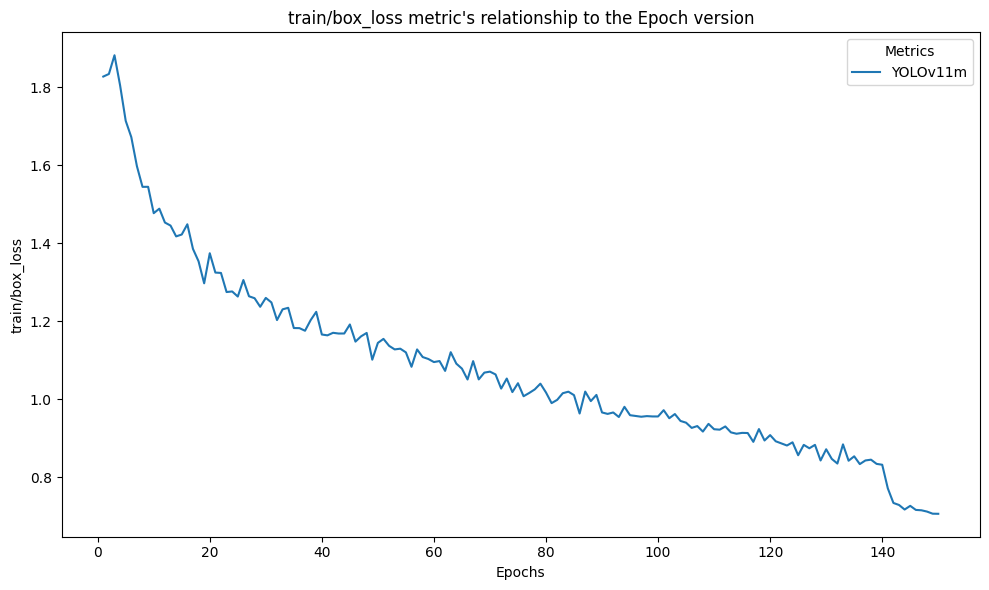

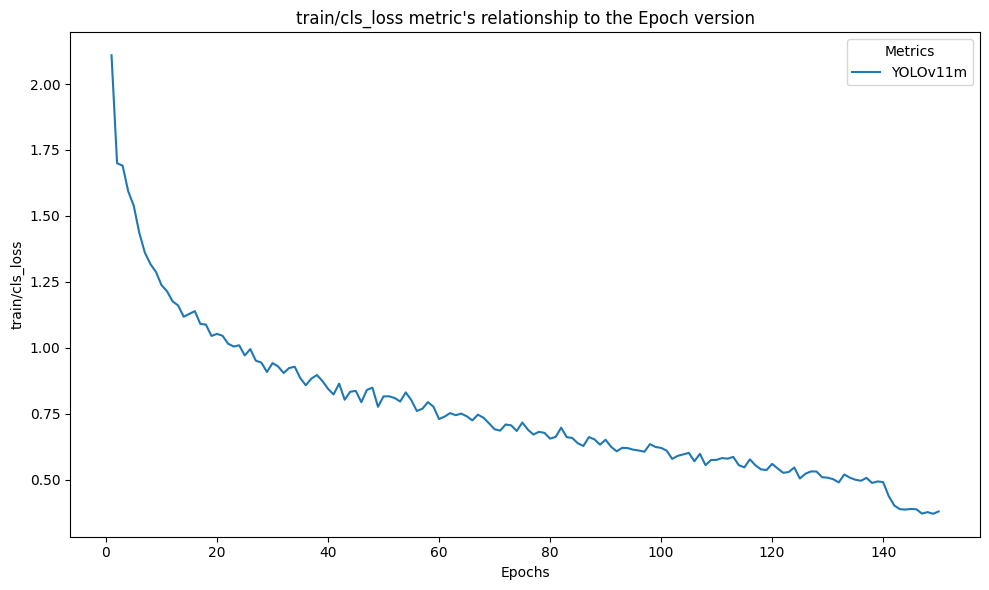

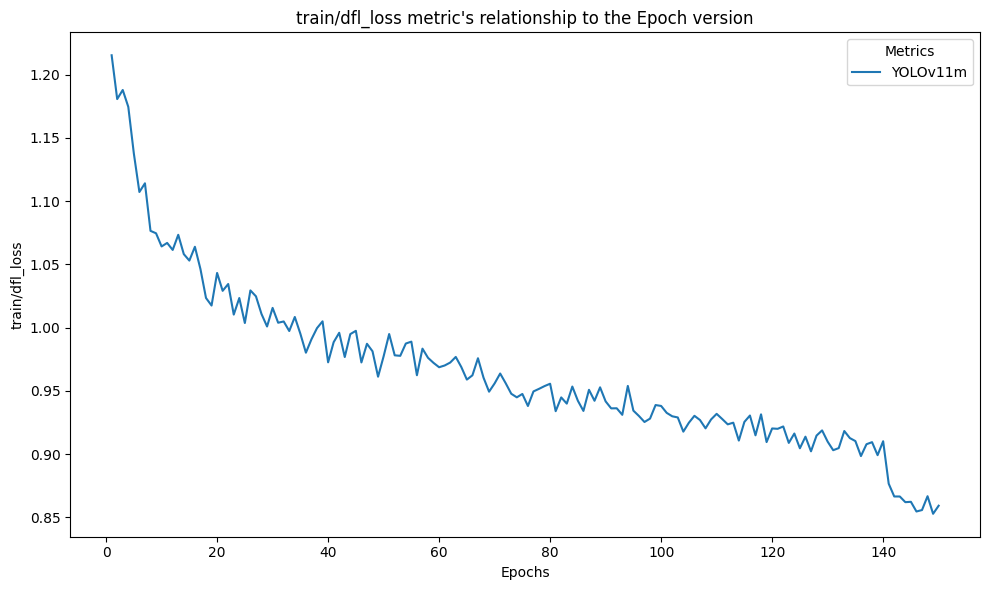

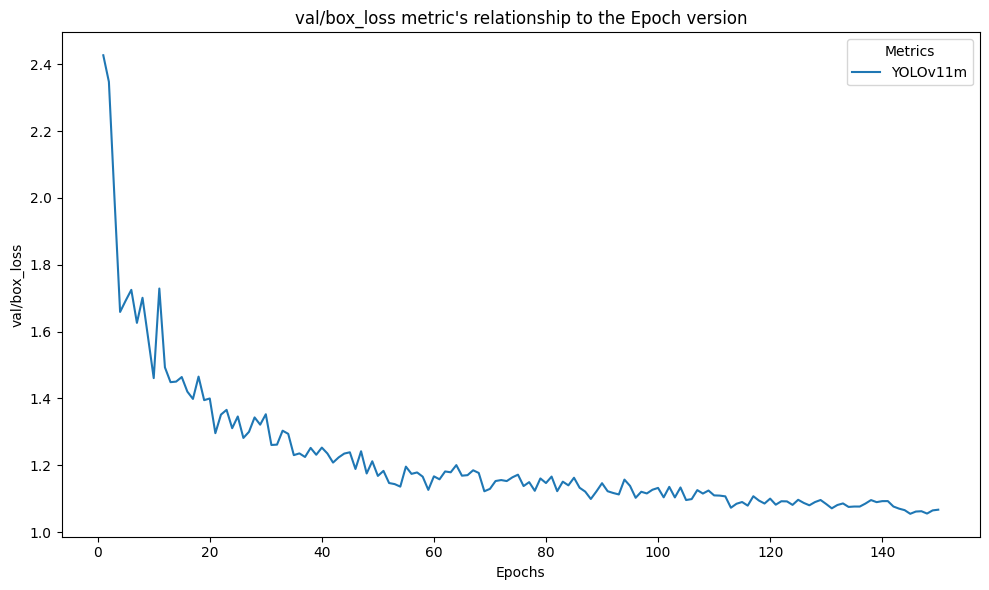

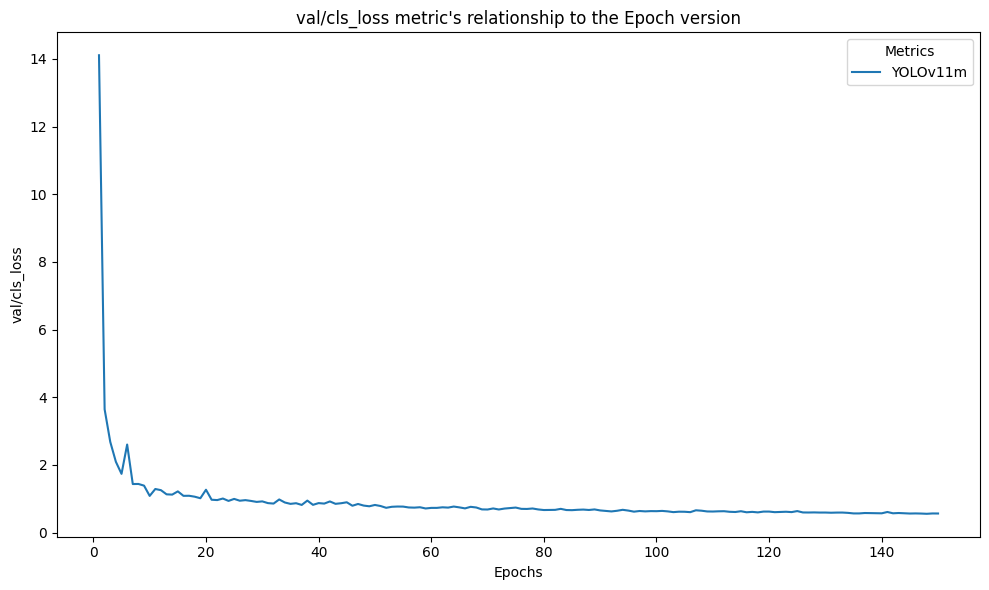

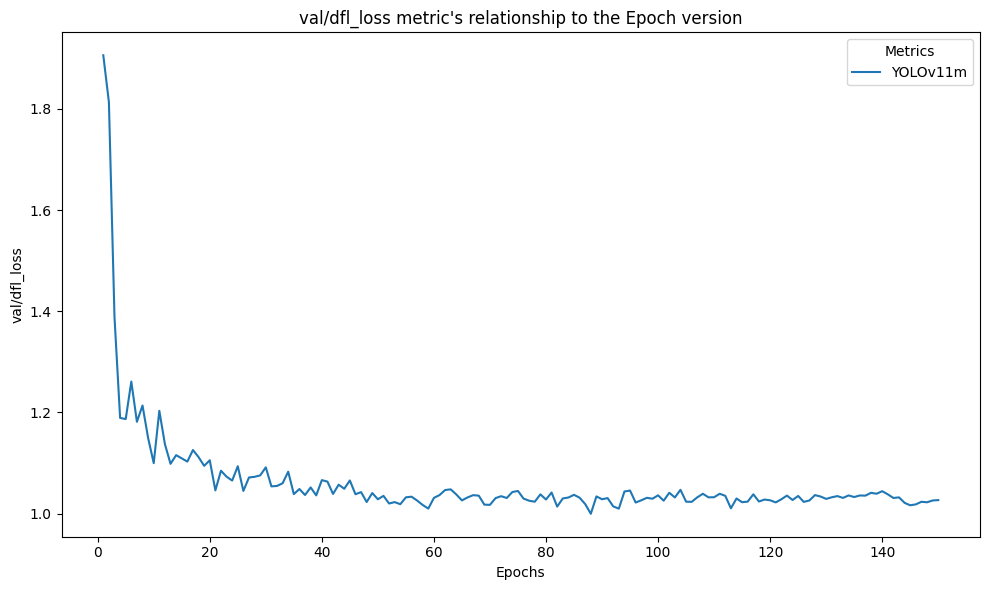

In [22]:
import pandas as pd
import seaborn as sns 

df = pd.read_csv('runs/detect/yolo12l.pt/results.csv')

metrics = ['train/box_loss','train/cls_loss','train/dfl_loss','val/box_loss','val/cls_loss','val/dfl_loss']

plt.figure(figsize=(10, 6))

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epoch', y=metric, data=df, label="YOLOv11m")
    
    plt.title(f"{metric} metric's relationship to the Epoch version")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.legend(title="Metrics")
    plt.tight_layout()
    
    plt.show()



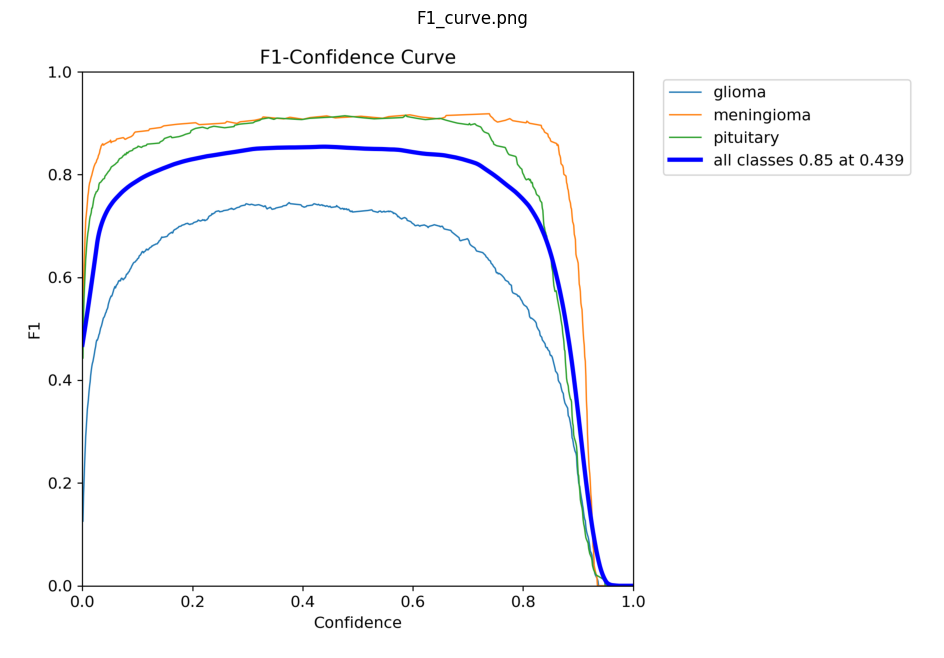

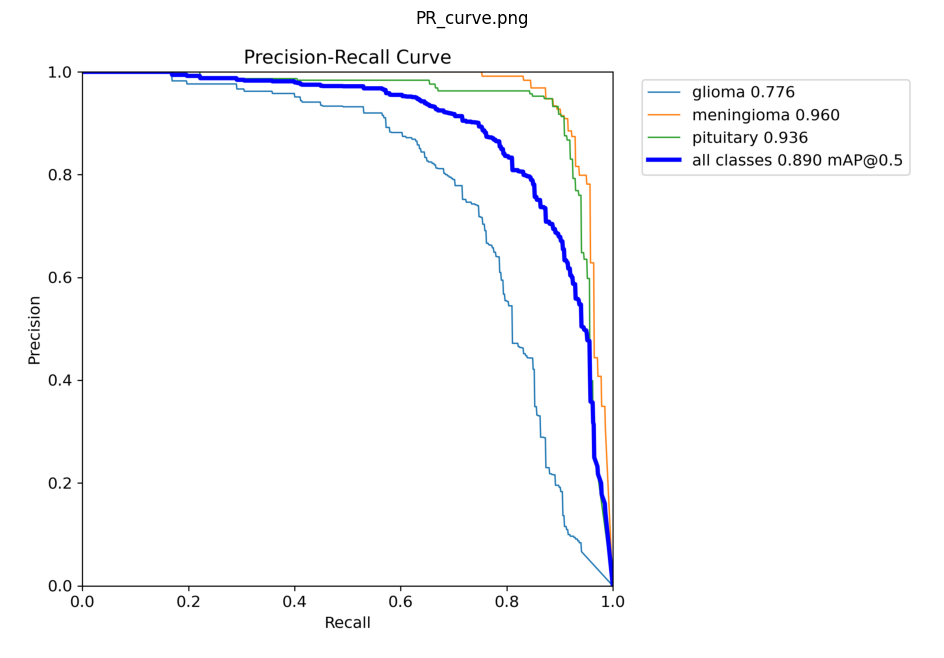

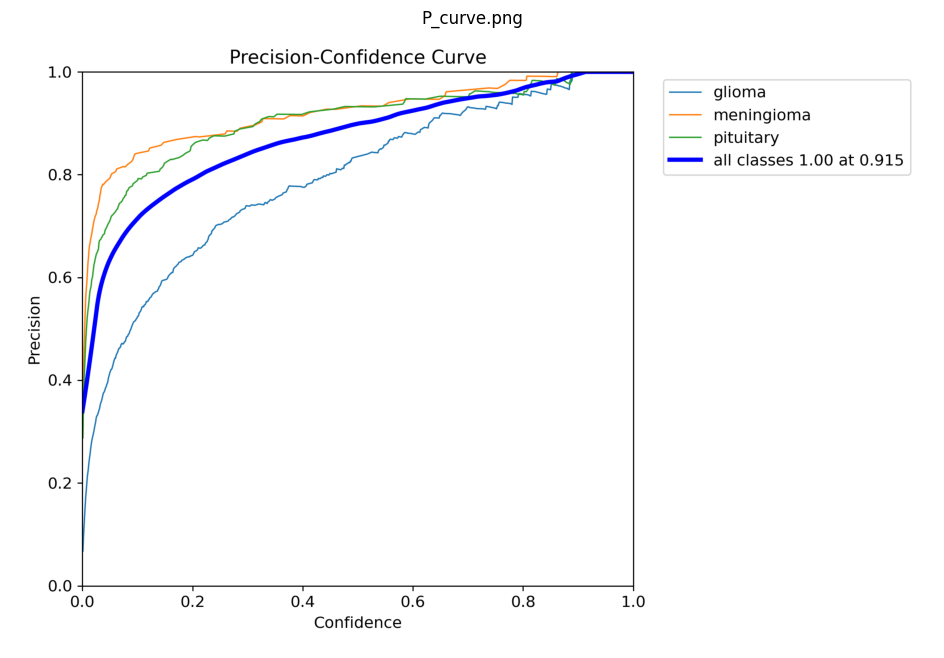

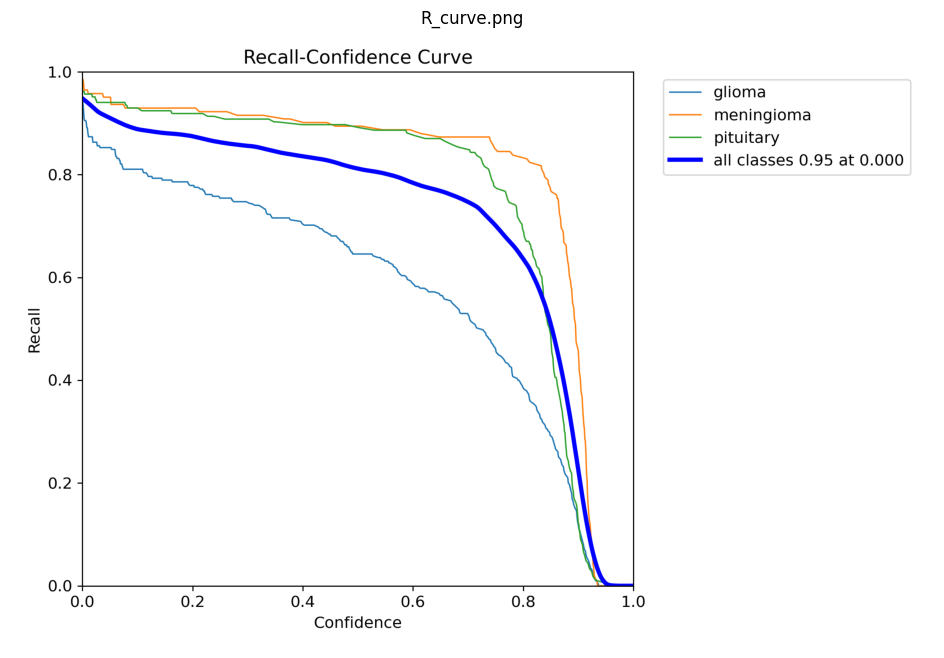

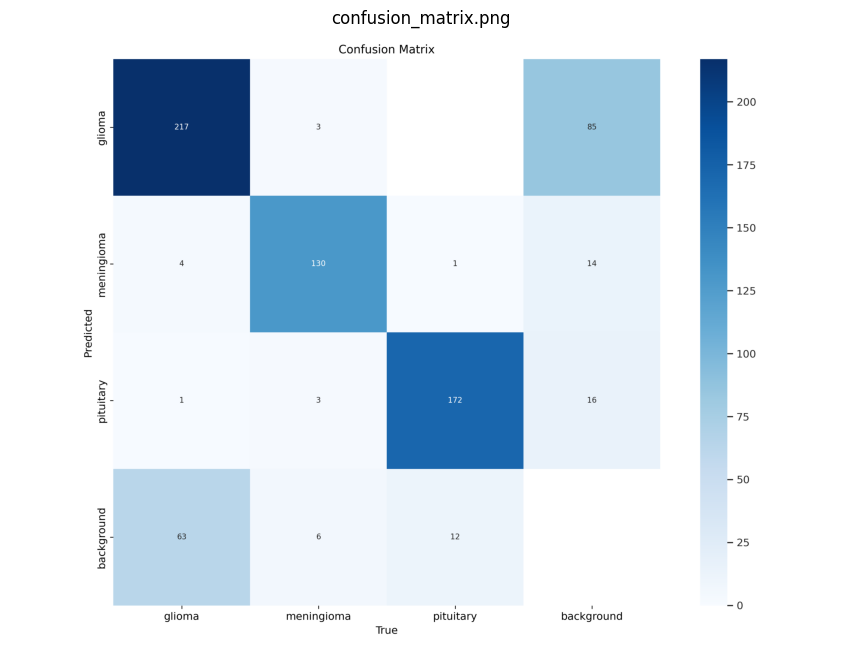

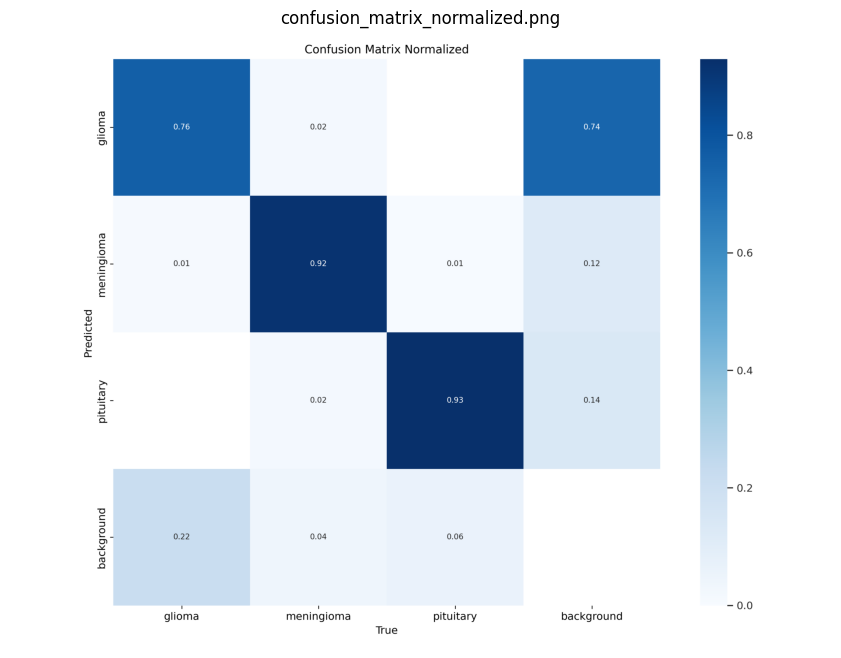

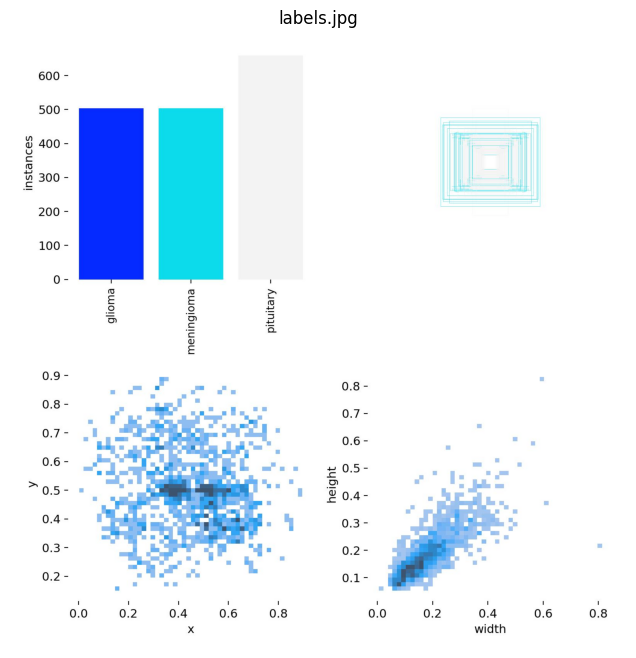

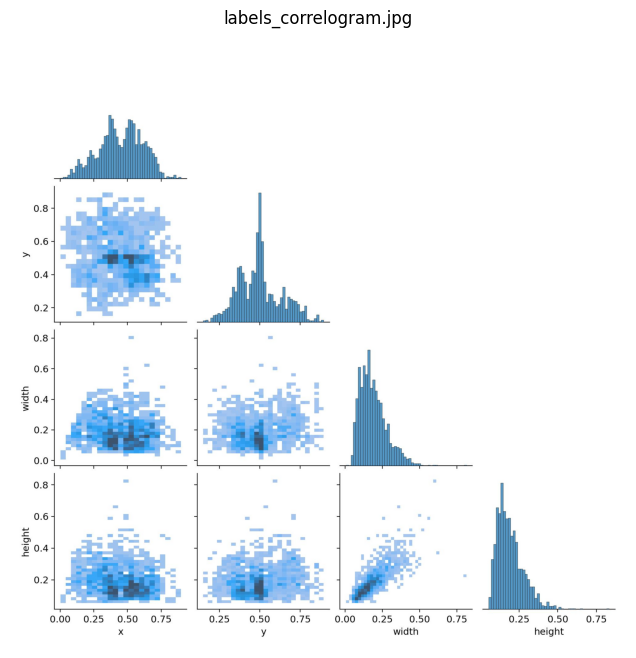

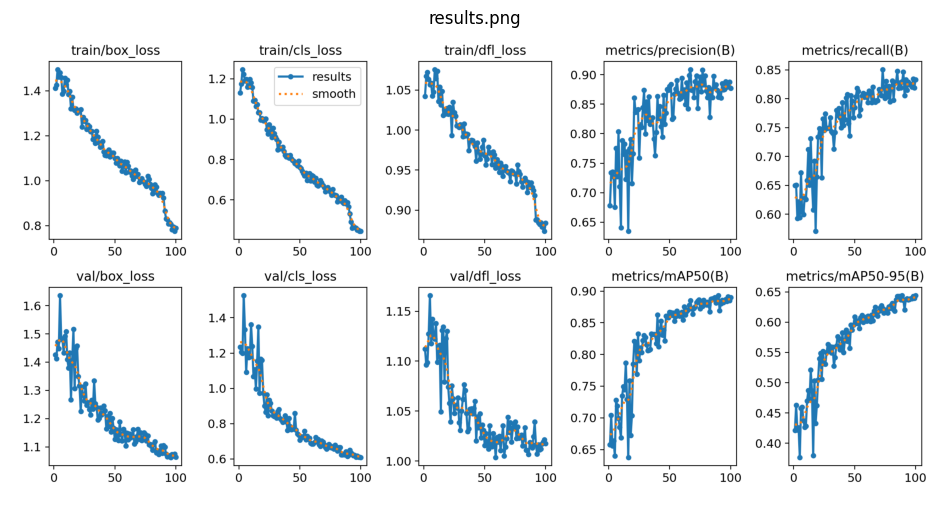

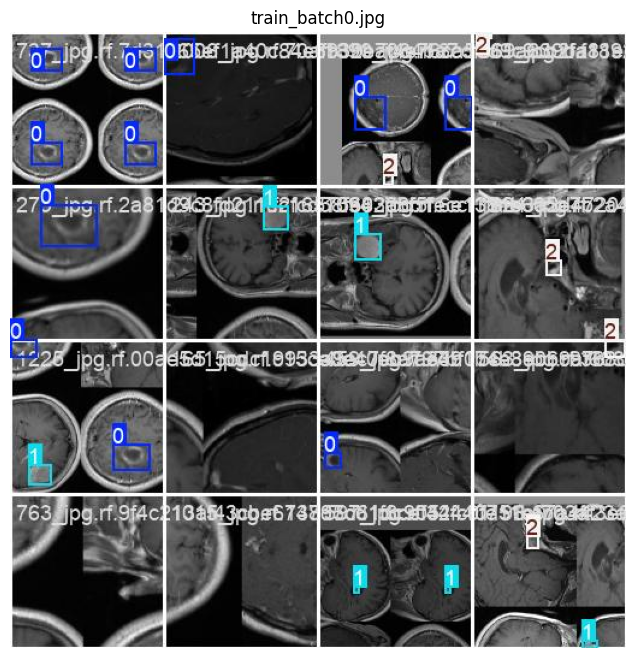

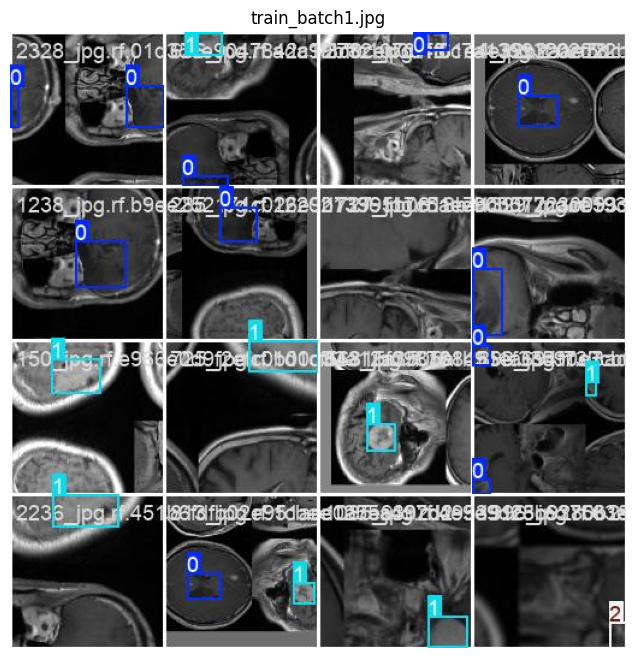

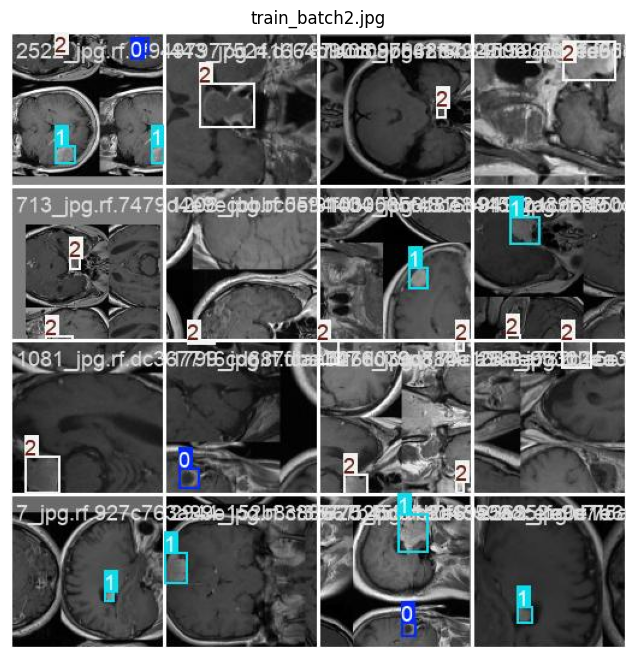

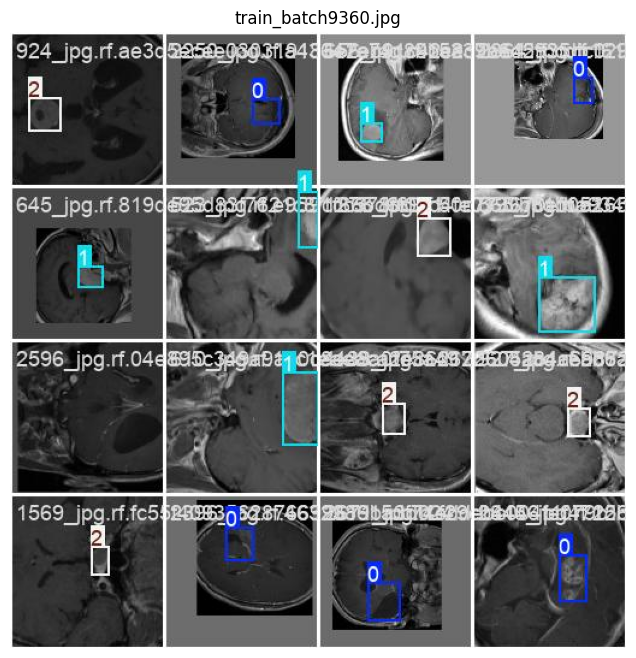

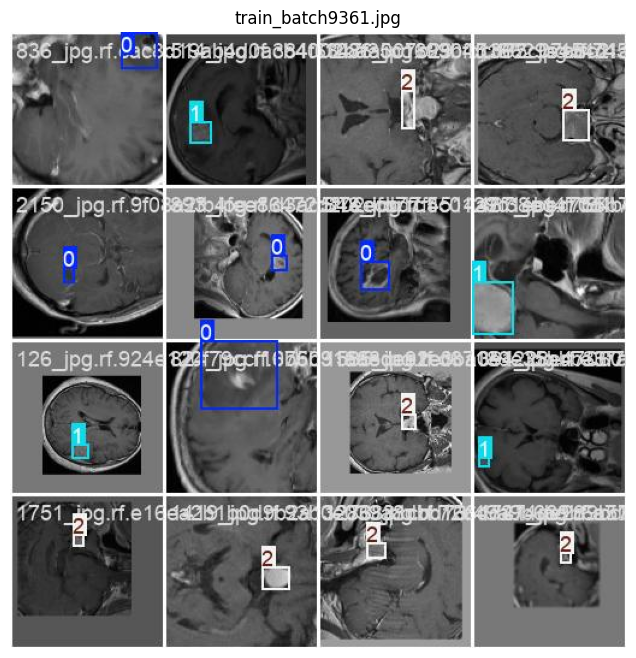

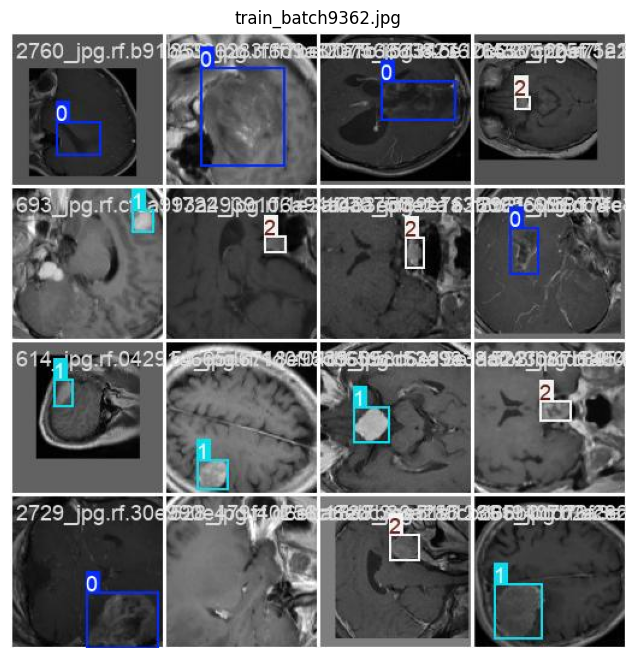

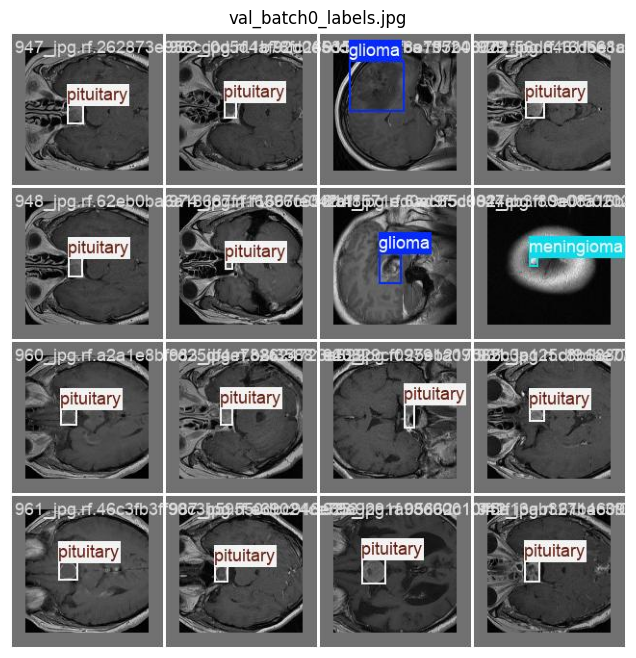

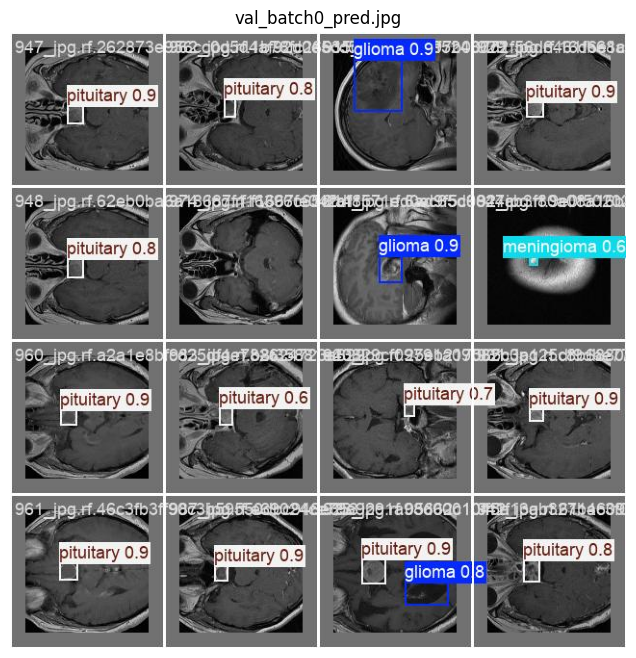

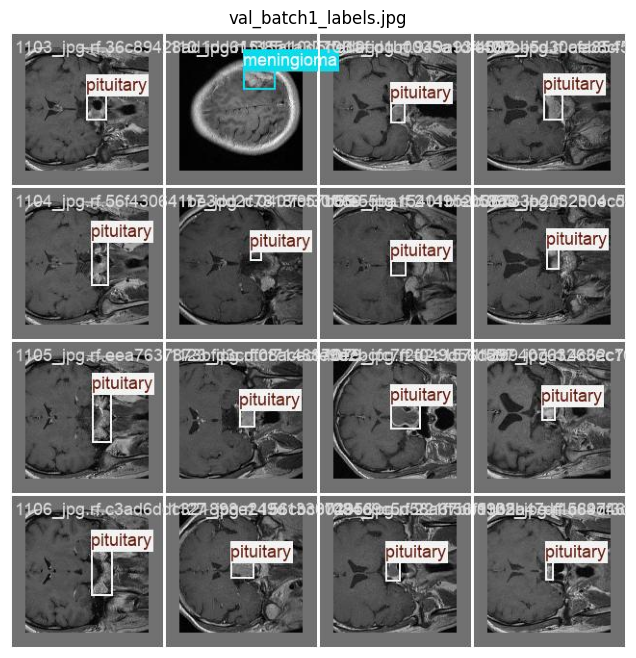

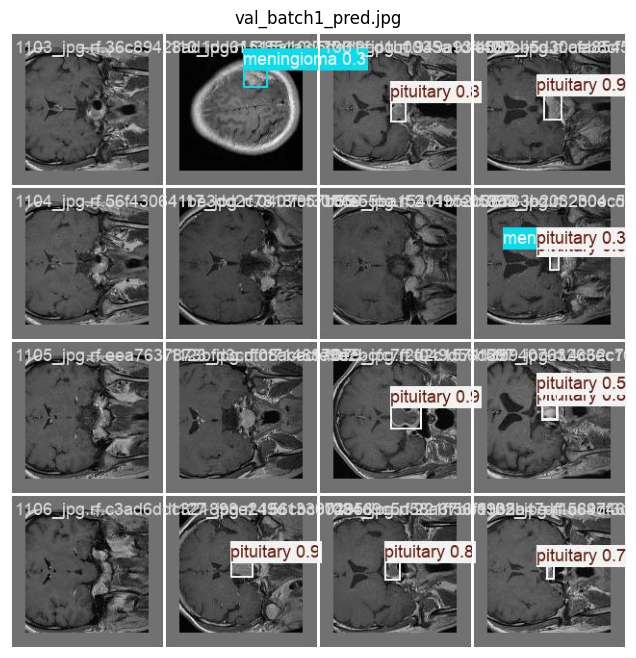

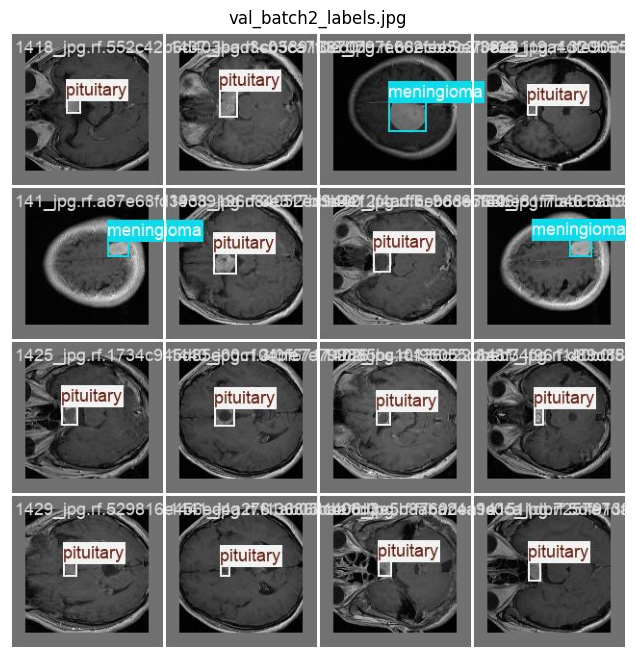

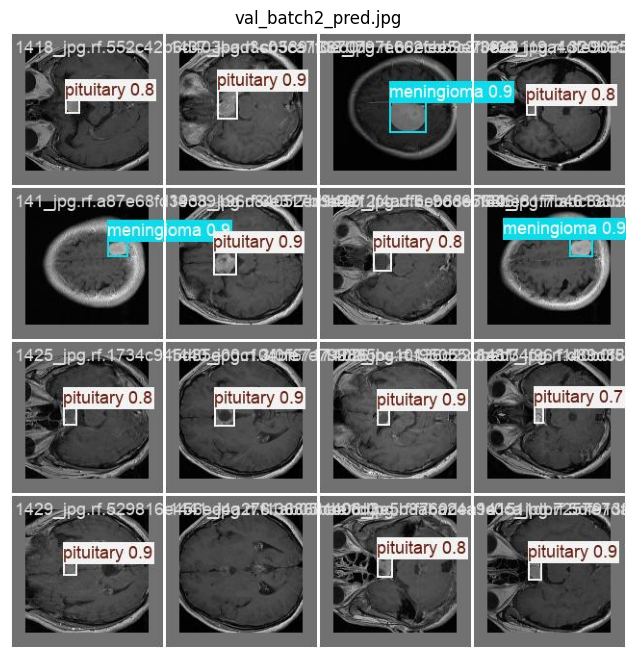

In [44]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/yolov12_m2"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()